# *DSHARP* Mie Opacity Package

### Introduction

This notebook demonstrates how to create/read our **current** set of opacities used in the DSHARP project or carries out other tests of the opacity package. This way we create the opacities in a transparent (open-source) way. In the near future, the opacities will be averaged over a narrow size distribution within each bin, to avoid resonance issues.

**Note:** All parts have their own `import` statements. This allows running those parts of the notebook separately. This also means that without the code to create the opacities, [**Part 2**](#Part-2:-Reading-in-from-default-format) can still be executed for reading in the resulting opacity files.

### Outline

- [**Part 1**](#Part-1:-Creating-the-LP-opacities) creates the default opacities (this part might be updated)
- [**Part 2**](#Part-2:-Reading-in-from-default-format) reads the created opacities (this part should stay the same)
- [**Part 3**](#Part-3:-Comparison-to-Ricci-et-al.-2010) compares the resulting opacities to the results shown in [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403)
- [**Part 4**](#Part-4:-Comparison-to-Draine-opacities) tests our Mie implementation to reproduce the astronomical silicates opacities by [Draine & Lee 1984](https://doi.org/10.1086/162480)
- [**Part 5**](#Part-5:-Test-large-grain-extrapolation) tests the extrapolation that can be used to speed up the calculations in the geometric optics limit.
- [**Part 6**](#Part-6:-Pollack-opacities) uses the Henning opacity database to calculate the [Pollack et al. 1994](https://doi.org/10.1086/173677) opacities and also recreates their Fig. 4 comparing the optical constants.
- [**Part 7**](#Part-7:-Large-Opacity-Values) compares the default mix from [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403), but varies the compactness & mixing rule.

### The Code

The opacity package used here is now part of `DISKLAB`. To install the Large Program Opacity package `lp_opac` you can download code from [github](https://github.com/dullemond/DISKLAB) once it's made public, change into that directory, and install the package with the command

    pip install -e .
    
Until then, you can use the copy in `p484/projects/opacity/disklab`.

-------------------------------------
## Part 1: Creating the LP opacities

### Procedure

The opacity is created in the following way, following [Ricci et al. 2010](https://dx.doi.org/10.1051/0004-6361/200913403):

| Optical constants                                                                | Volume fractions [%] | material density [g/cm^3] |
|:---------------------------------------------------------------------------------|---------------------:|--------------------------:|
| Astronomical Silicates: [Draine 2003](https://dx.doi.org/10.1086/379123)         |           7          |            3.50           |
| Carbon  grains: [Zubko et al. 1996](https://dx.doi.org/10.1093/mnras/282.4.1321) |          21          |            2.50           |
| Water ice: [Warren & Brandt 2008](https://dx.doi.org/10.1029/2007JD009744)       |          42          |            1.00           |
| Vacuum                                                                           |          30          |            0.00           |

The mixing of the optical constants is done according to the Bruggeman mixing rule and the opacities are calculated using a Bohren & Huffman Mie code, more specifically a Fortran 90 translation of [Bruce Draines `bhmie.f`](https://www.astro.princeton.edu/~draine/scattering.html) code.

Imports for this part:

In [1]:
import numpy as np
from disklab import opacity

Here we create the opacities: note that the large grains at short wavelength take very long to calculate. We can use extrapolation for that by setting `extrapolate_large_grains=True` which make it very fast, but for the extreme cases ($a>1$ cm, $\lambda < 50\mu$m) this leads to a few percent error, and for the most extreme cases ($a>10$ cm, $\lambda < 0.2\mu$m) to an error of 30%.

In [2]:
a = np.logspace(-5, 2, 200)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

res = opacity.get_opacities(a, lam, return_all=True, extrapol=True, extrapolate_large_grains=False)

k_abs = res['k_abs']
k_sca = res['k_sca']
g     = res['g']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
rho_s = res['rho_s']

Note: wavelength range outside data. Extrapolation will be done but is uncertain.
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
Mie ... 0 %

/Users/birnstiel/CODES/DISKLAB_FORK/disklab/opacity/lp_opac.py:1447: UserWarning: large size parameter: nmx=96666242.08825111 - this can take long
  warnings.warn('large size parameter: nmx={} - this can take long'.format(nmx))


Mie ... Done!


Store the data

In [3]:
np.savez_compressed('default_opacities', a=a, lam=lam, k_abs=k_abs.T, k_sca=k_sca.T, g=g)

--------------------------------
## Part 2: Reading in from default format

This part demonstrates how to read in the pre-calculated opacities. As we update [Part 1](#Part-1:-Creating-the-LP-opacities), the opacities might change slightly, but this part should stay the same.

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use([{'figure.dpi':150, 'image.cmap':'rocket'}])

Loading the data

In [2]:
with np.load('default_opacities.npz') as data:
    a = data['a']
    lam = data['lam']
    k_abs = data['k_abs']
    k_sca = data['k_sca']
    g = data['g']

Example plot: opacities of the smallest grains as function of wavelength

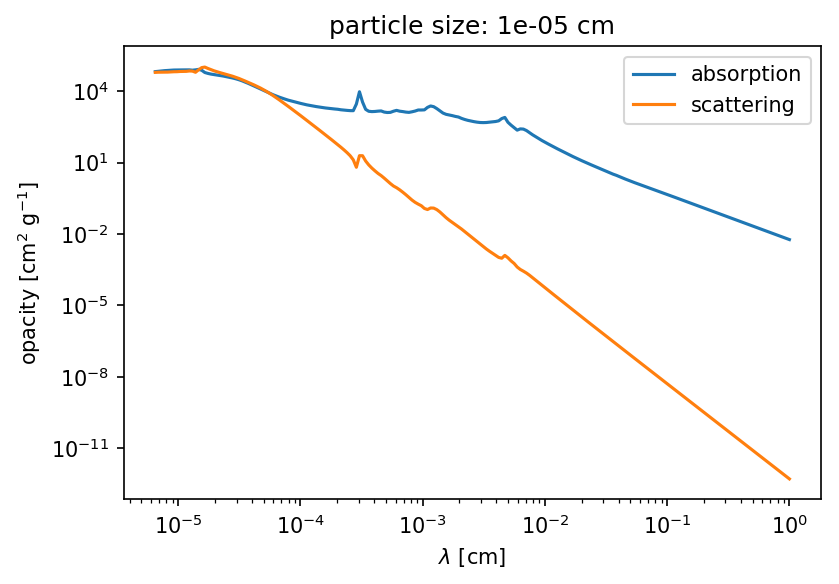

In [3]:
ia = 0
f, ax = plt.subplots()
ax.loglog(lam, k_abs[:, ia], label='absorption')
ax.loglog(lam, k_sca[:, ia], label='scattering')
ax.set_title(f'particle size: {a[ia]} cm')
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

Example plot: opacities at 880 µm as function of particle size

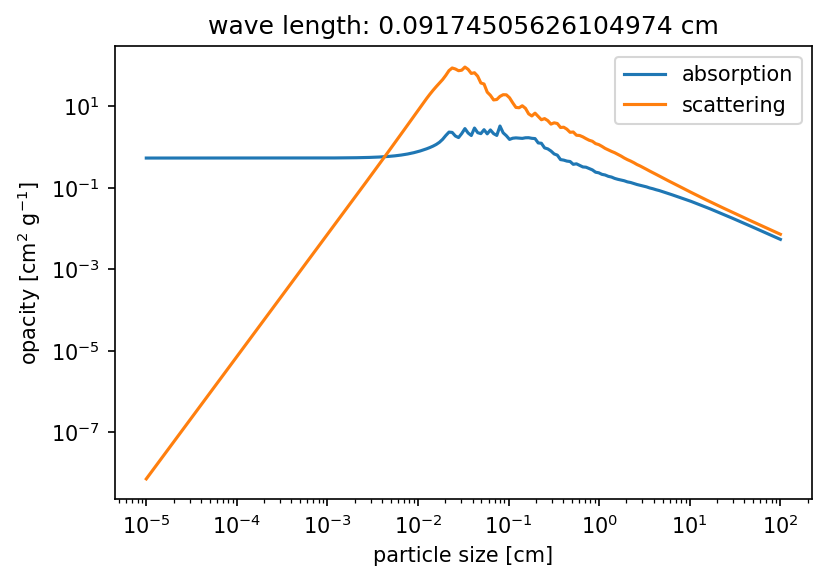

In [4]:
ilam = lam.searchsorted(0.088)
f, ax = plt.subplots()
ax.loglog(a, k_abs[ilam, :], label='absorption')
ax.loglog(a, k_sca[ilam, :], label='scattering')
ax.set_title('wave length: {} cm'.format(lam[ilam]))
ax.set_ylabel('opacity [cm$^2$ g$^{-1}$]')
ax.set_xlabel('particle size [cm]')
ax.legend();

------------------------------------------
## Part 3: Comparison to Ricci et al. 2010

Comparison of size-averaged opacities to Luca Riccis data file.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
from pkg_resources import resource_filename
plt.style.use(['seaborn',{'figure.dpi':150}])

from disklab import opacity

Load default opacity from file

In [2]:
data = np.load('default_opacities.npz')

a = data['a']
lam = data['lam']
k_abs = data['k_abs']
k_sca = data['k_sca']
g = data['g']

Load Lucas averaged opacity data.

In [3]:
datafile = resource_filename(opacity.__name__, os.path.join('optical_constants', 'testfiles_ricci', 'kappa.dat'))
k_ricci = np.loadtxt(datafile)
datafile = resource_filename(opacity.__name__, os.path.join('optical_constants', 'testfiles_ricci', 'beta.dat'))
beta_ricci = np.loadtxt(datafile)

Compare the averaged opacity curves

kappa_abs @       1 mm for a_max = 1mm : 1.36 cm^2/g
kappa_abs @       3 mm for a_max = 1mm : 0.179 cm^2/g


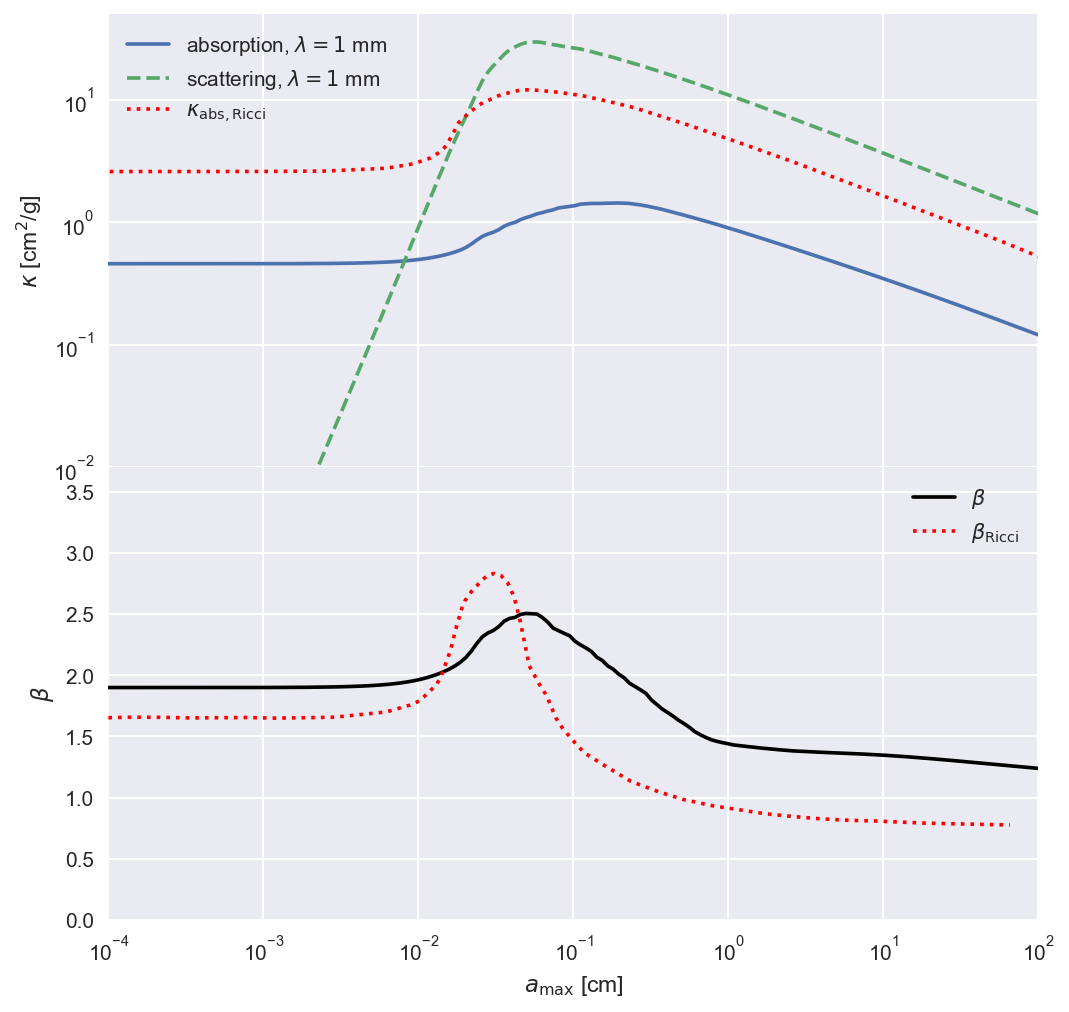

In [4]:
lam_avg = [0.1, 0.3]
f, ax = plt.subplots(2,1,figsize=(8, 8), sharex=True)
f.subplots_adjust(hspace=0)

res = opacity.size_average_opacity(lam_avg, a, lam, k_abs.T, k_sca.T, plot=True, ax=ax)

for ilam, _lam in enumerate(lam_avg):
    print('kappa_abs @ {:7.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(_lam *10, np.interp(_lam, a, res['ka'][ilam])))
    
ax[0].loglog(k_ricci[:, 0], k_ricci[:, 1], 'r:', label=r'$\kappa_\mathrm{abs, Ricci}$')
lines = ax[0].get_lines()
ax[0].legend(lines,[_l.get_label() for _l in lines])

ax[1].semilogx(beta_ricci[:, 0], beta_ricci[:, 1], 'r:', label=r'$\beta_\mathrm{Ricci}$')
lines = ax[1].get_lines()
ax[1].legend(lines,[_l.get_label() for _l in lines]);
ax[1].set_ylim(ymax = 3.7);

-----------------------------------------
## Part 4: Comparison to Draine opacities

To check if our Mie calculation works properly, we compare our calculaitons to the results from [Bruce Draines](https://www.astro.princeton.edu/~draine/dust/dust.diel.html) website, which has both the optical properties and the opacities.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn',{'figure.dpi':150}])

from disklab import opacity

In [2]:
a = np.logspace(-5, 2, 150)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

# draine optical constants go only until 1mm, so we extrapolate

dc = opacity.diel_drainelee84_astrosil()
dc.extrapolate_constants_up(4e-2, 1e0, kind='linear')

res = opacity.get_mie_coefficients(a, lam, dc, extrapolate_large_grains=True)

Mie ... Done!


Read pre-calculated opacities for 0.1 µm particles from [Bruce Draines](https://www.astro.princeton.edu/~draine/dust/dust.diel.html) website:

In [3]:
from urllib.request import urlopen
with urlopen('ftp://ftp.astro.princeton.edu/draine/dust/diel/Sil_21') as f:
    
    # skip to the right particle size
    
    line = b''
    while not f.readline().decode().startswith('1.000E-01 = radius(micron)'):
        pass
    line = f.readline()
    
    # read the right number of lines
    
    draine = np.loadtxt([f.readline() for i in range(241)])

Plot the calculated opacity against the one on Bruce Draines website.

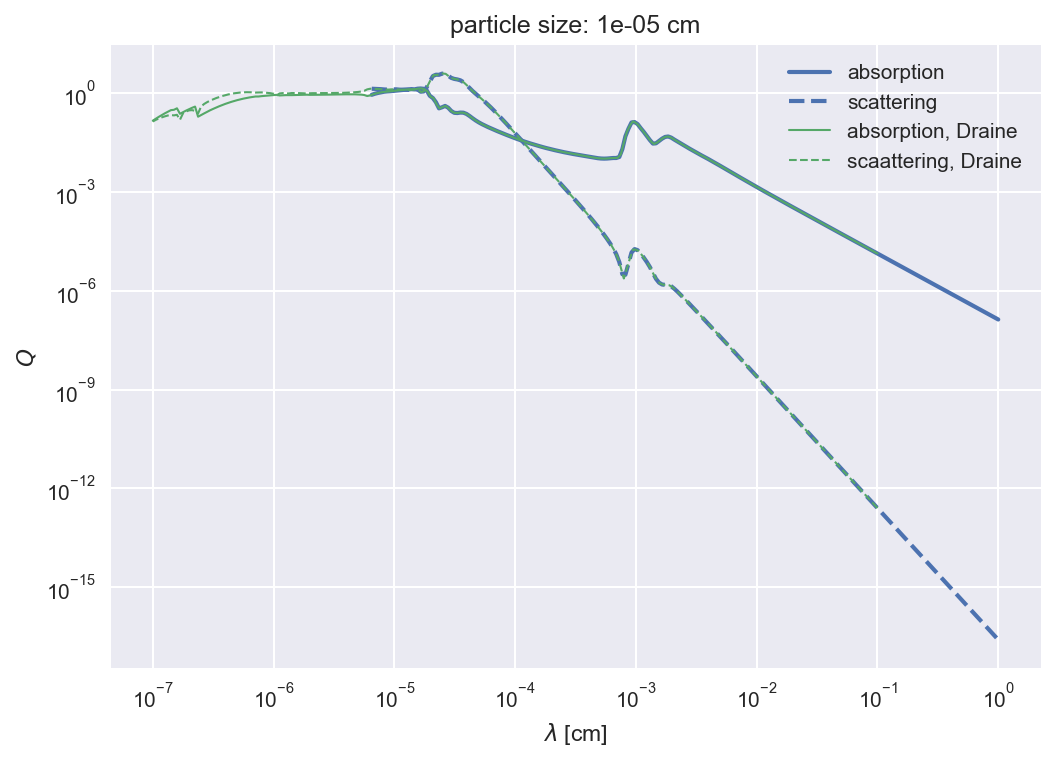

In [4]:
ia = 0
f, ax = plt.subplots()
line1, = ax.loglog(lam, res['q_abs'][ia, :], '-',      lw=2, label='absorption')
line2, = ax.loglog(lam, res['q_sca'][ia, :], '--',     lw=2, label='scattering', c=line1.get_color())
line3, = ax.loglog(draine[:,0]*1e-4, draine[:,1], '-', lw=1, label='absorption, Draine')
line4, = ax.loglog(draine[:,0]*1e-4, draine[:,2], '--',lw=1, label='scaattering, Draine', c=line3.get_color())

ax.set_title(f'particle size: {a[ia]:.2g} cm')
ax.set_ylabel('$Q$')
ax.set_xlabel('$\lambda$ [cm]')
ax.legend();

Calculate $\beta$ as function of $a_\mathrm{max}$:

kappa_abs @       1 mm for a_max = 1mm : 3.09 cm^2/g
kappa_abs @       3 mm for a_max = 1mm : 0.439 cm^2/g


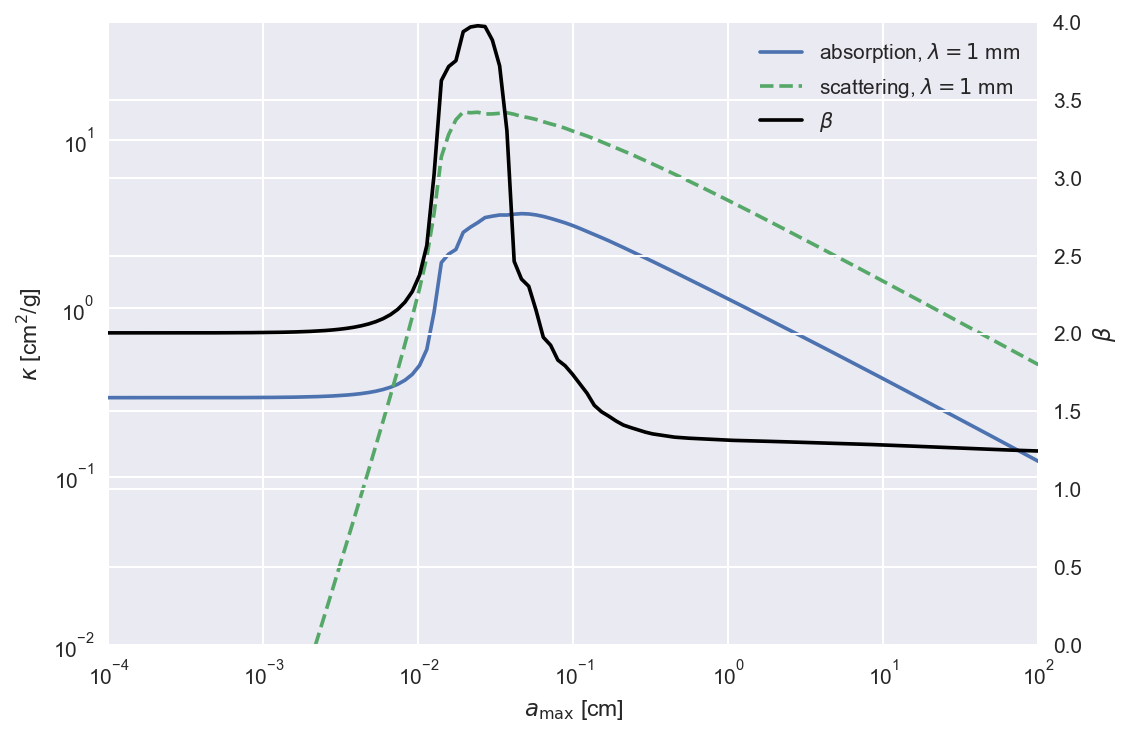

In [5]:
rho_s = 3.5
m     = 4.0 * np.pi / 3.0 * rho_s * a**3
k_abs, k_sca = opacity.get_kappa_from_q(a, m, res['q_abs'], res['q_sca'])

lam_avg = [0.1, 0.3]
res2 = opacity.size_average_opacity(lam_avg, a, lam, k_abs, k_sca, plot=True)
for ilam, _lam  in enumerate(lam_avg):
    print('kappa_abs @ {:7.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(_lam * 10, np.interp(_lam, a, res2['ka'][ilam])))

-----------------------------------------
## Part 5: Test large grain extrapolation

For large size parameters (large grains and short wavelength), the Mie solution needs many terms. In this case, we can also use a direct extrapolation since we are in the geometric optics case. In this part, we compare those two approaches.

The file `default_opacities.npz` was created in [Part 1](#Part-1:-Creating-the-LP-opacities), the file `default_opacities_extr.npz` was created in the same way, but setting `extrapolate_large_grains=True`.

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use([{'figure.dpi':100, 'image.cmap':'rocket'}])

Loading the data

In [2]:
d      = np.load('default_opacities.npz')
a      = d['a']
lam    = d['lam']
k_abs  = d['k_abs']
k_sca  = d['k_sca']

d2     = np.load('default_opacities_extr.npz')
k_abs2 = d2['k_abs']
k_sca2 = d2['k_sca']

Plot the opacities and the errors

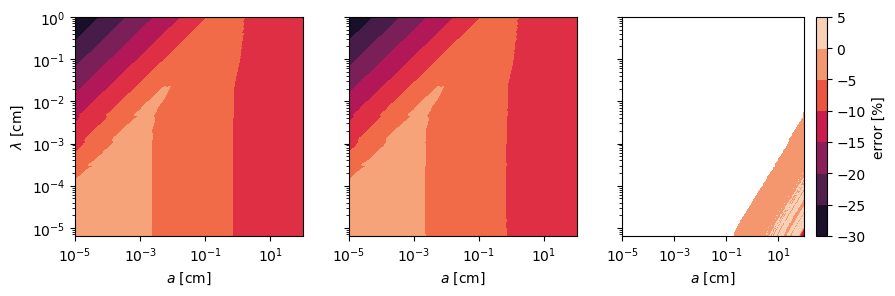

In [3]:
f, ax = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True)

ax[0].contourf(a, lam, np.log10(k_sca))
ax[1].contourf(a, lam, np.log10(k_sca2))
for _a in ax:
    _a.set_xscale('log')
    _a.set_yscale('log')
    _a.set_xlabel('$a$ [cm]')
    
ax[0].set_ylabel('$\lambda$ [cm]')
    
err = k_sca/k_sca2-1
cc = ax[2].contourf(a, lam, np.ma.array(err*100, mask=err==0))
cb = plt.colorbar(cc)
cb.set_label('error [%]')
f.subplots_adjust(bottom=0.15, hspace=0)
f.savefig('opacitiy_comparison.pdf')

----------------------------
## Part 6: Pollack opacities

Here we try to reproduce the opacities of [Pollack et al. 1994](https://doi.org/10.1086/173677). For the optical constants, we use the ones provided by [Thomas Henning](http://www2.mpia-hd.mpg.de/home/henning/Dust_opacities/Opacities/RI/old_ri.html), specifically the old ones. For the Refractory and volatile organics, we use the same optical properties. As mixing rule, we use Maxwell-Garnett, as in the Pollack paper.

$\bar\rho$ = 1.3785 g/cc


| Species            | Bulk Density [g/cm^3] | mass fraction total | mass fraction normalized | volume fraction |
|:-------------------|:----------------------|:--------------------|:-------------------------|:----------------|
| Metallic iron      | 7.87                  | 1.26e-4             | 0.00900901               | 0.00157800      |
| Olivine            | 3.49                  | 2.64e-3             | 0.18876019               | 0.07455709      |
| Orthopyroxene      | 3.40                  | 7.70e-4             | 0.05505506               | 0.02232144      |
| Troilite           | 4.83                  | 7.68e-4             | 0.05491205               | 0.01567200      |
| Refractory organic | 1.50                  | 3.53e-3             | 0.25239525               | 0.23194974      |
| Volatile organic   | 1.00                  | 6.02e-4             | 0.04304304               | 0.05933445      |
| Water ice          | 0.92                  | 5.55e-3             | 0.39682540               | 0.59458728      |

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from disklab import opacity
plt.style.use(['seaborn-ticks', {'figure.dpi': 100}])

In [2]:
# get the optical constants

d1 = opacity.diel_henning('waterice',      new=False)
d2 = opacity.diel_henning('iron',          new=False)
d3 = opacity.diel_henning('olivine',       new=False)
d4 = opacity.diel_henning('orthopyroxene', new=False)
d5 = opacity.diel_henning('troilite',      new=False)
d6 = opacity.diel_henning('organics',      new=False)
d7 = opacity.diel_henning('organics',      new=False)


# define arrays for optical constants, bulk densities, and volume fractions for each species

constants = [d1, d2, d3, d4, d5, d6, d7]
densities = np.array([0.92, 7.87, 3.49, 3.40, 4.83, 1.50, 1.00])
vol_fract = np.array([
    0.59458728,
    0.00157800,
    0.07455709,
    0.02232144,
    0.01567200,
    0.23194974,
    0.05933445
    ])

# calculate the mean density, needed to get opacity in units of cm^2/g

rho_s = (vol_fract*densities).sum()

# mix the optical constants using the Maxwell-Garnett rule

d = opacity.diel_mixed(constants, vol_fract, rule='Maxwell-Garnett')

Reading opacities from waterice
Reading opacities from iron
Reading opacities from olivine
Reading opacities from orthopyr
Reading opacities from troilite
Reading opacities from organics
Reading opacities from organics
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Waterice (Henning)


Calculate the Mie opacities, this takes quite long if `extrapolate_large_grains=False`.

In [3]:
a = np.logspace(-5, 2, 150)
lam = np.logspace(np.log10(1e-5), 0, 206)

res = opacity.get_opacities(a, lam, rho_s=rho_s, diel_const=d, return_all=True, extrapol=True, extrapolate_large_grains=True)

k_abs = res['k_abs']
k_sca = res['k_sca']
g     = res['g']
S1    = res['S1']
S2    = res['S2']
theta = res['theta']
rho_s = res['rho_s']

Mie ... Done!


Redo [Fig. 1](http://adsbit.harvard.edu//full/1994ApJ...421..615P/0000624.000.html) from Pollack et al. 1994 paper to compare optical constants.

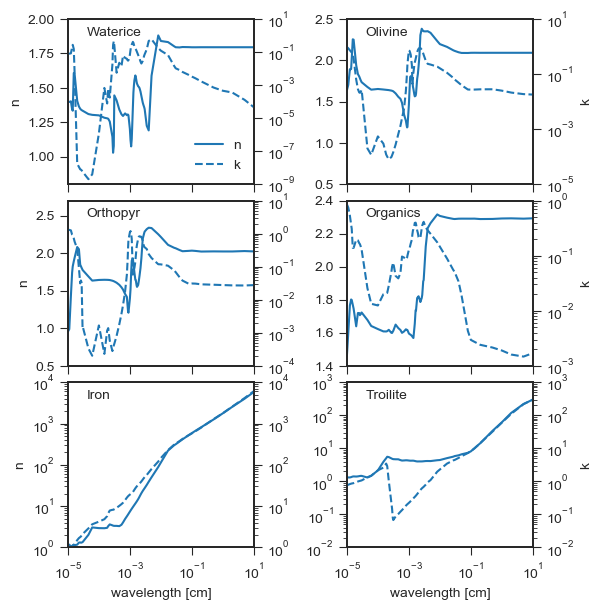

In [4]:
f, axs = plt.subplots(3,2, figsize=(6,7), sharex=True)

plot_const = [d1, d3, d4, d6, d2, d5]

axs = axs.ravel()
axs2 = []
for c,ax in zip(plot_const, axs):

    # plot real part

    line1, = ax.semilogx(c._l, c._n, '-', label='n')

    # plot imaginary part

    ax2 = ax.twinx()
    line2, = ax2.loglog(c._l, c._k, '--', label='k')
    axs2 +=[ax2]

    # add name of the species

    ax.text(.1,.9,
            os.path.splitext(os.path.split(c.datafile)[1])[0].capitalize(),
            horizontalalignment='left',
            transform=ax.transAxes)

    # add legend to first panel

    if len(axs2)==1:
        lns = [line1,line2]
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc=4)

# adjust the labels

for ax in axs[:-2]:
    plt.setp(ax.get_xticklabels(), visible=False)
for ax in axs[-2:]:
    ax.set_xlabel('wavelength [cm]')
for ax in axs[0::2]:
    ax.set_ylabel('n')
for ax in axs2[1::2]:
    ax.set_ylabel('k')

# use same limits as in pollack paper

axs[0].set_ylim(0.8,2.0)
axs[1].set_ylim(0.5,2.5)
axs[2].set_ylim(0.5,2.7)
axs[3].set_ylim(1.4,2.4)
axs[4].set_ylim(1e0,1e4)
axs[4].set_yscale('log')
axs[5].set_ylim(1e-2,1e3)
axs[5].set_yscale('log')

axs2[0].set_ylim(1e-9,1e1)
axs2[1].set_ylim(1e-5,1e1)
axs2[2].set_ylim(1e-4,1e1)
axs2[3].set_ylim(1e-3,1e0)
axs2[4].set_ylim(1e-0,1e4)
axs2[5].set_ylim(1e-2,1e3)

axs[0].set_xlim(1e-5, 1e1)

f.subplots_adjust(hspace=0.1, wspace=0.5)
f.savefig('pollack_optical_constants.pdf')

Calculate $\beta$ as function of $a_\mathrm{max}$:

kappa_abs @    0.88 mm for a_max = 1mm : 1.9 cm^2/g
kappa_abs @       1 mm for a_max = 1mm : 1.54 cm^2/g


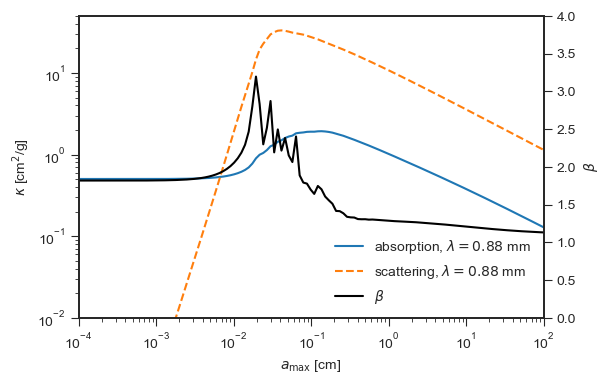

In [5]:
lam_avg =[0.088, 0.1]
r = opacity.size_average_opacity(lam_avg, a, lam, res['k_abs'], res['k_sca'], plot=True)
for i, _lam in enumerate(lam_avg):
    print('kappa_abs @ {:7.3g} mm for a_max = 1mm : {:.3g} cm^2/g'.format(_lam *10, np.interp(_lam, a, r['ka'][i])))

-------------------------------
## Part 7: Large Opacity Values

Here we try the separate ingredients to the Ricci et al. 2010 mix to find the cause of the large opacities

Imports for this part:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

from disklab import opacity
plt.style.use(['seaborn-ticks', {'figure.dpi': 100}])

Specify the original values as in the default case

In [2]:
c0 = opacity.diel_vacuum()
c1 = opacity.diel_warrenbrandt08()
c2 = opacity.diel_zubko96(extrapol=True, lmax=2)
c3 = opacity.diel_draine2003('astrosilicates')

constants = [c0, c1, c2, c3]

# after Lucas thesis, the fractions in Ricci+2010 are typos

vol_fract = [0.30, 0.42, 0.21, 0.07]
densities = [0.00, 1.00, 2.50, 3.50]
rho_s = (np.array(vol_fract)*densities).sum()

Define size & wavelength grids for this part

In [3]:
a = np.logspace(np.log10(5e-7), 2, 150)
lam = np.logspace(np.log10(6.5e-6), 0, 206)

lam_obs = 0.087
a_max = 0.1

**Step 1:** Calculate the single compact material properties

Mie ... Done!
Water Ice (Warren & Brandt 2008) 0.87 mm opacity   1.9 cm^2/g
Mie ... Done!
Carbonaceous Grains (Zubko et al. 1996, ACH2) - extrapolated 0.87 mm opacity   7.1 cm^2/g
Mie ... Done!
Astronomical Silicates (Draine 2003) 0.87 mm opacity   3.7 cm^2/g


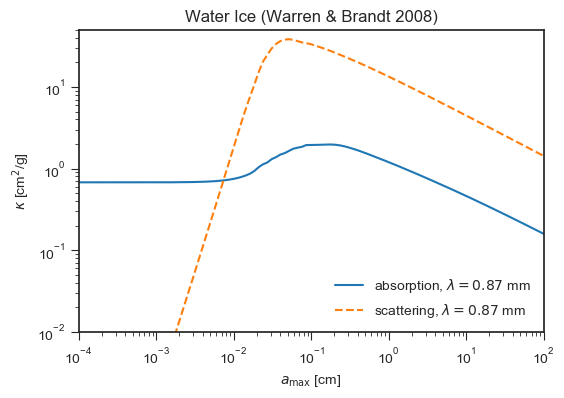

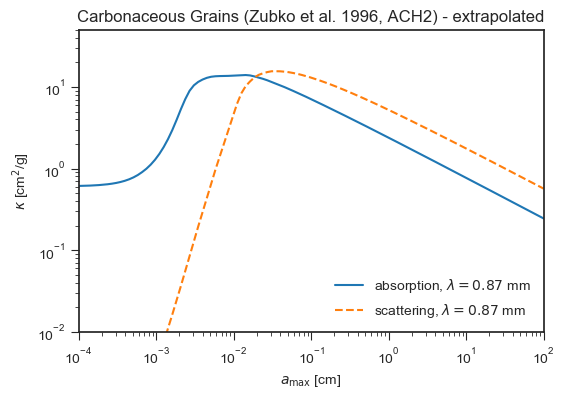

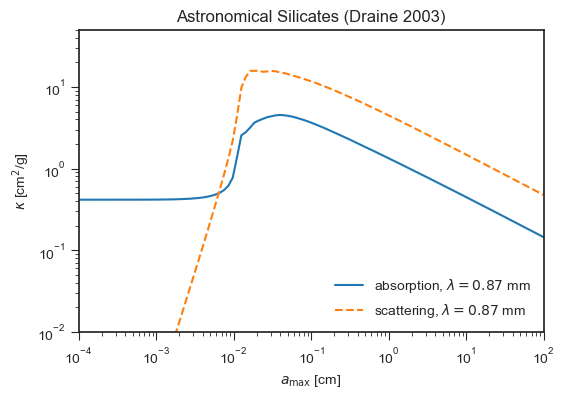

In [4]:
for rho, const in zip(densities, constants):

    if const.material_str == 'Vacuum':
        continue

    res   = opacity.get_opacities(a, lam, rho_s=rho, diel_const=const, extrapolate_large_grains=True)

    res2 = opacity.size_average_opacity(lam_obs, a, lam, res['k_abs'], res['k_sca'], plot=True);
    res2['ax1'].set_title(const.material_str)
    print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(const.material_str, lam_obs * 10,np.interp(a_max, a, res2['ka'][0])))

**Step 2:** Calculate the *compact/porous* version of the Ricci opacities using both mixing rules

Mie ... Done!
Bruggeman-Mix of 4 species 0.87 mm opacity    13 cm^2/g
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
Mie ... Done!
Maxwell-Garnett-Mix of 4 species 0.87 mm opacity   1.9 cm^2/g
Mie ... Done!
Bruggeman-Mix of 3 species 0.87 mm opacity    24 cm^2/g
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Water Ice (Warren & Brandt 2008)
Mie ... Done!
Maxwell-Garnett-Mix of 3 species 0.87 mm opacity    16 cm^2/g


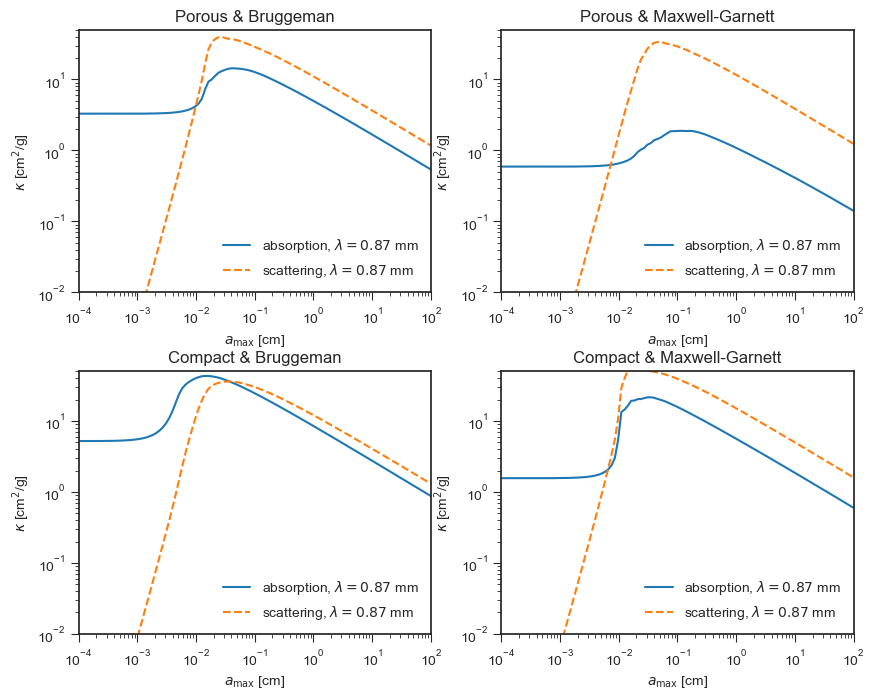

In [5]:
# the compact version of the mix

constants_comp = [c1, c2, c3]
vol_comp = np.array(vol_fract[:-1])
vol_comp /= vol_comp.sum()
rho_comp = (densities[:-1]*vol_comp).sum()

f, axs = plt.subplots(2, 2, figsize=(10,8))
f.subplots_adjust(hspace=0.3, wspace=0.2)
axs = axs.ravel()
i = 0

for S, V, C, R in zip(['Porous', 'Compact'], [vol_fract, vol_comp], [constants, constants_comp], [rho_s, rho_comp]):
    for rule in ['Bruggeman', 'Maxwell-Garnett']:
        ax = axs[i]

        dm = opacity.diel_mixed(C, V, rule=rule)
        res = opacity.get_opacities(a, lam, rho_s=R, diel_const=dm, extrapolate_large_grains=True)

        res2 = opacity.size_average_opacity(lam_obs, a, lam, res['k_abs'], res['k_sca'], plot=True, ax=ax)
        ax.set_title(S+' & '+rule)
        print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(dm.material_str, lam_obs *10, np.interp(a_max, a, res2['ka'][0])))
        i+=1

**Step 3:** Testing the Kataoka 2-step mixing process (1 MG mix of the materials, another MG mix of material and vacuum)

In [6]:
c0 = opacity.diel_vacuum()
c1 = opacity.diel_warrenbrandt08()
c2 = opacity.diel_zubko96(extrapol=True, lmax=2)
c3 = opacity.diel_draine2003('astrosilicates')

constants = [c0, c1, c2, c3]

# CASE 1 & 2: after Lucas thesis, but without vacuum, both rules

vol_fract_1 = [0.00, 0.42, 0.21, 0.07]
vol_fract_1 = vol_fract_1/np.array(vol_fract_1).sum()
densities   = [0.00, 1.00, 2.50, 3.50]
rho_s_1     = (np.array(vol_fract_1) * densities).sum()

# first step: mix with both rules

mix_a_1 = opacity.diel_mixed(constants, vol_fract_1, rule='Maxwell-Garnett')
mix_b_1 = opacity.diel_mixed(constants, vol_fract_1, rule='Bruggeman')

# second step: now mix this with vacuum as "matrix"

vol_fract_2 = [0.3, 0.7]
densities_2 = [0.0, rho_s_1]
rho_s_a     = (np.array(vol_fract_2)*densities_2).sum()

mix_a = opacity.diel_mixed([opacity.diel_vacuum(), mix_a_1], vol_fract_2, rule='Maxwell-Garnett')
mix_b = opacity.diel_mixed([opacity.diel_vacuum(), mix_b_1], vol_fract_2, rule='Maxwell-Garnett')

# CASE 3 & 4: we mix porosity in from the beginning with both rules

vol_fract_c = [0.30, 0.42, 0.21, 0.07]
rho_s_c     = (np.array(vol_fract_c)*densities).sum()
mix_c       = opacity.diel_mixed(constants, vol_fract_c, rule='Maxwell-Garnett')
mix_d       = opacity.diel_mixed(constants, vol_fract_c, rule='Bruggeman')

# calculate the opacities

res_a = opacity.get_opacities(a, lam, rho_s=rho_s_a, diel_const=mix_a, extrapolate_large_grains=True)
res_b = opacity.get_opacities(a, lam, rho_s=rho_s_a, diel_const=mix_b, extrapolate_large_grains=True)
res_c = opacity.get_opacities(a, lam, rho_s=rho_s_c, diel_const=mix_c, extrapolate_large_grains=True)
res_d = opacity.get_opacities(a, lam, rho_s=rho_s_c, diel_const=mix_d, extrapolate_large_grains=True)

# a fifth case, where we do a mass weighted mix of optical constants

fm = densities/rho_s_c * vol_fract_c

res_1 = opacity.get_opacities(a, lam, rho_s=densities[1], diel_const=c1, extrapolate_large_grains=True)
res_2 = opacity.get_opacities(a, lam, rho_s=densities[2], diel_const=c2, extrapolate_large_grains=True)
res_3 = opacity.get_opacities(a, lam, rho_s=densities[3], diel_const=c3, extrapolate_large_grains=True)

k_a_mw = fm[1]*res_1['k_abs'] + fm[2]*res_2['k_abs'] + fm[3]*res_3['k_abs']
k_s_mw = fm[1]*res_1['k_sca'] + fm[2]*res_2['k_sca'] + fm[3]*res_3['k_sca']

using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Vacuum
Mie ... Done!
Mie ... Done!
Mie ... Done!
Mie ... Done!
Mie ... Done!
Mie ... Done!
Mie ... Done!


Plot the resulting size average opacities as function of $a_\mathrm{max}$

Maxwell-Garnett-Mix of 2 species 0.87 mm opacity   1.9 cm^2/g
Maxwell-Garnett-Mix of 2 species 0.87 mm opacity    13 cm^2/g
Maxwell-Garnett-Mix of 4 species 0.87 mm opacity   1.9 cm^2/g
Bruggeman-Mix of 4 species 0.87 mm opacity    13 cm^2/g
mass weighted 0.87 mm opacity   4.6 cm^2/g


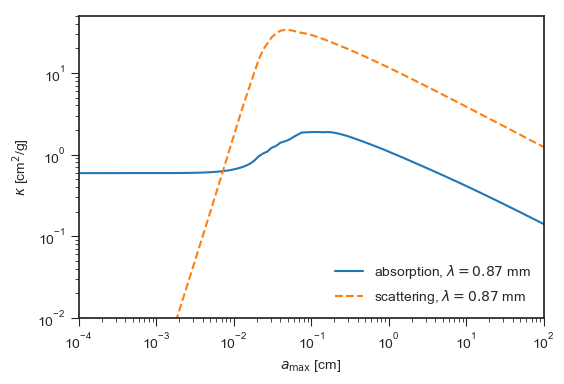

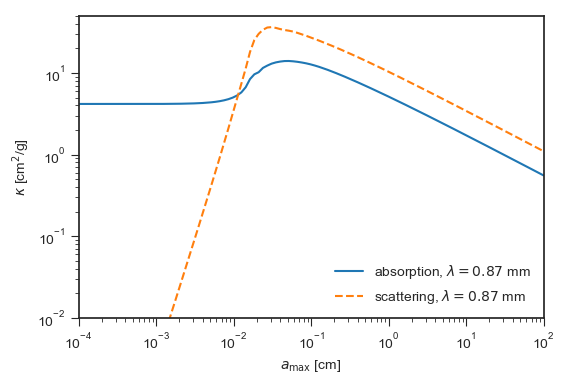

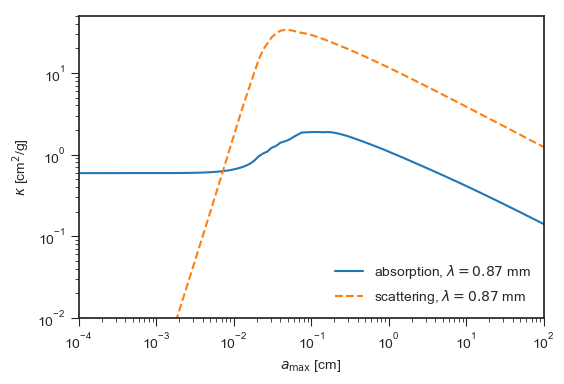

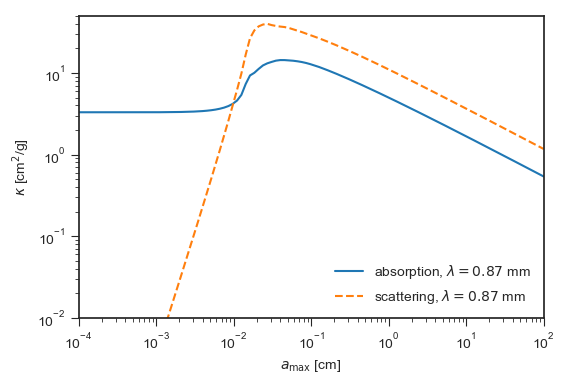

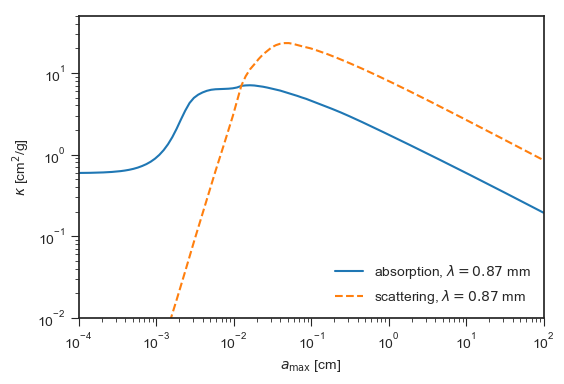

In [7]:
mean_a = opacity.size_average_opacity(lam_obs, a, lam, res_a['k_abs'], res_a['k_sca'], plot=True)
print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(mix_a.material_str, lam_obs * 10, np.interp(a_max, a, mean_a['ka'][0])))
ax.set_title('First MG for materials, then MG for vacuum')
plt.savefig('1.pdf')

mean_b = opacity.size_average_opacity(lam_obs, a, lam, res_b['k_abs'], res_b['k_sca'], plot=True)
print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(mix_b.material_str, lam_obs * 10, np.interp(a_max, a, mean_b['ka'][0])))
ax.set_title('First B for materials, then MG for vacuum')
plt.savefig('2.pdf')

mean_c = opacity.size_average_opacity(lam_obs, a, lam, res_c['k_abs'], res_c['k_sca'], plot=True)
print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(mix_c.material_str, lam_obs * 10, np.interp(a_max, a, mean_c['ka'][0])))
ax.set_title('MG with vacuum as matrix')
plt.savefig('3.pdf')

mean_d = opacity.size_average_opacity(lam_obs, a, lam, res_d['k_abs'], res_d['k_sca'], plot=True)
print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format(mix_d.material_str, lam_obs * 10, np.interp(a_max, a, mean_d['ka'][0])))
ax.set_title('B rule mixing everything')
plt.savefig('4.pdf')

mean_mw = opacity.size_average_opacity(lam_obs, a, lam, k_a_mw, k_s_mw, plot=True)
print('{} {:.2} mm opacity {:5.2g} cm^2/g'.format('mass weighted', lam_obs * 10, np.interp(a_max, a, mean_mw['ka'][0])))
ax.set_title('mass weighted')
plt.savefig('5.pdf')

**Step 4:** A **very rough** try to reproduce the WD2001 mix

Download one of the Weingartner & Draine 2001 dust models

In [8]:
from urllib.request import urlopen
with urlopen('ftp://ftp.astro.princeton.edu/draine/dust/mix/kext_albedo_WD_MW_3.1_60') as f:
    while not f.readline().decode().startswith('--------'):
        pass
    lam_dr,_,_,_,k_dr = np.loadtxt(f).T

We also use a grain size distribution with a similar extent as in the WD01 paper, but we use just MRN slope instead of the more complex size distributions from their paper.

In [9]:
aMRN = np.logspace(np.log10(3.5e-8), np.log10(1e-4), 100)

# for silicates, graphite

rho   = [3.5, 2.24]
v     = [0.59, 0.41]
rho_d = (np.array(v)*rho).sum()

# get the silicates and extrapolate

draine_sil = opacity.diel_WD2001_astrosil()
draine_sil.extrapolate_constants_up(0.05,1,kind='linear')

# mix the graphite grains

draine_c1  = opacity.diel_draine2003('graphite', parallel=False, a='0.01')
draine_c2  = opacity.diel_draine2003('graphite', parallel=True, a='0.01')
draine_c   = opacity.diel_mixed([draine_c1, draine_c2], [2. / 3, 1. / 3], rule='Maxwell-Garnett')

# mix the graphite with the silicates

draine     = opacity.diel_mixed([draine_sil, draine_c], v, rule='Maxwell-Garnett')
res_draine = opacity.get_opacities(aMRN, lam, rho_s=rho_d, diel_const=draine, extrapolate_large_grains=True)

# make a mass weighted pseudo-WD opacity

res_draine_s = opacity.get_opacities(aMRN, lam, rho_s=rho[0], diel_const=draine_sil, extrapolate_large_grains=True)
res_draine_c = opacity.get_opacities(aMRN, lam, rho_s=rho[1], diel_const=draine_c, extrapolate_large_grains=True)

# a mrn-size distribution and size average

s_draine = aMRN**0.5
s_draine = s_draine/s_draine.sum()

k_draine_s = (res_draine_s['k_abs'] * s_draine[:, None]).sum(0)
k_draine_c = (res_draine_c['k_abs'] * s_draine[:, None]).sum(0)

# now a mass weighted sum

fm_draine = rho/rho_d*v
k_d_mw = k_draine_s*fm_draine[0] + k_draine_c * fm_draine[1]

using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Graphite, pe, a=0.01 mu (Laor & Draine 1993)
using Maxwell-Garnett mixing: first component should be host material (= matrix)
    matrix = Astronomical Silicates (Weingartner & Draine 2001) - extrapolated
Mie ... Done!
Mie ... Done!
Mie ... Done!


**Step 5:** Plot all of those tests in a similar way as Fig. 3 of [Andrews et al. 2009](https://dx.doi.org/10.1088/0004-637X/700/2/1502).

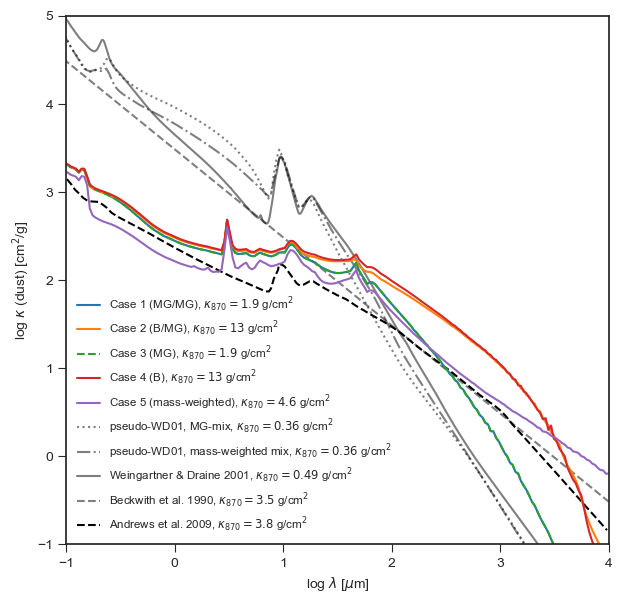

In [10]:
# a 1g-normalized size distribution (bin-integrated) up to 1 mm

s = a**0.5
s[a>0.1]=0
s= s/s.sum()

# size average all the absorption opacities

k1 = (res_a['k_abs'] * s[:,None]).sum(0)
k2 = (res_b['k_abs'] * s[:,None]).sum(0)
k3 = (res_c['k_abs'] * s[:,None]).sum(0)
k4 = (res_d['k_abs'] * s[:,None]).sum(0)
k5 = (k_a_mw * s[:,None]).sum(0)
kd = (res_draine['k_abs'] * s_draine[:,None]).sum(0)
kb = 3.5*(lam/0.087)**(-1)  # Beckwith 1990

la,ka = np.loadtxt('data/andrews2009.dat').T

f, ax = plt.subplots(figsize=(7,7))

ax.plot(np.log10(1e4*lam), np.log10(k1),       label='Case 1 (MG/MG), $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(        lam_obs*1e4, np.interp(lam_obs,lam,k1)))
ax.plot(np.log10(1e4*lam), np.log10(k2),       label='Case 2 (B/MG), $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(         lam_obs*1e4, np.interp(lam_obs,lam,k2)))
ax.plot(np.log10(1e4*lam), np.log10(k3), '--', label='Case 3 (MG), $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(           lam_obs*1e4, np.interp(lam_obs,lam,k3)))
ax.plot(np.log10(1e4*lam), np.log10(k4),       label='Case 4 (B), $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(            lam_obs*1e4, np.interp(lam_obs,lam,k4)))
ax.plot(np.log10(1e4*lam), np.log10(k5),       label='Case 5 (mass-weighted), $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(lam_obs*1e4, np.interp(lam_obs,lam,k5)))

ax.plot(np.log10(1e4*lam), np.log10(kd),     'k:',  zorder=-100, alpha=0.5, label='pseudo-WD01, MG-mix, $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(           lam_obs*1e4, np.interp(lam_obs,lam,kd)))
ax.plot(np.log10(1e4*lam), np.log10(k_d_mw), 'k-.', zorder=-100, alpha=0.5, label='pseudo-WD01, mass-weighted mix, $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(lam_obs*1e4, np.interp(lam_obs,lam,k_d_mw)))
ax.plot(np.log10(lam_dr),  np.log10(k_dr),   'k',   zorder=-100, alpha=0.5, label='Weingartner & Draine 2001, $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(     lam_obs*1e4, np.interp(lam_obs*1e4,lam_dr,k_dr)))
ax.plot(np.log10(1e4*lam), np.log10(kb),     'k--', zorder=-100, alpha=0.5, label='Beckwith et al. 1990, $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(          lam_obs*1e4, np.interp(lam_obs,lam,kb)))
ax.plot(np.log10(la),      np.log10(ka),     'k--', zorder=-100, alpha=1.0, label='Andrews et al. 2009, $\kappa_{{{:.0f}}} = {:3.2g}$ g/cm$^2$'.format(           lam_obs*1e4, np.interp(lam_obs*1e4,la,ka)))

ax.legend(loc=3, fontsize='small')
ax.set_xlim(-1,4)
ax.set_ylim(-1,5)
ax.set_xlabel('log $\lambda$ [$\mu$m]')
ax.set_ylabel('log $\kappa$ (dust) [cm$^2$/g]')
plt.savefig('andrews09-like.pdf')